Notebook to explore dataset of expression data. 

In [1]:
# Load necessary libraries
library(tidyverse)
library(DESeq2)
library(tximport)
library(GenomicFeatures)
library(AnnotationDbi)
library(org.Hs.eg.db) # Replace with the appropriate organism database


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’

In [2]:

# Define file paths
salmon_dir <- "/workspaces/ATAi/nf_rnaseq_successful_run/star_salmon/"
gene_counts_file <- file.path(salmon_dir, "salmon.merged.gene_counts.tsv")
gene_tpm_file <- file.path(salmon_dir, "salmon.merged.gene_tpm.tsv")
tx2gene_file <- file.path(salmon_dir, "tx2gene.tsv")

In [3]:
# Function to read and inspect BBSplit stats files
read_bbsplit_stats <- function(file_path) {
  data <- read_tsv(file_path, col_names = FALSE)
  colnames(data) <- c("stat", "value")
  return(data)
}

# Read and inspect all BBSplit stats files
bbsplit_path <- "/workspaces/ATAi/nf_rnaseq_successful_run/bbsplit"
bbsplit_files <- list.files(bbsplit_path, pattern = "*.stats.txt", full.names = TRUE)
bbsplit_stats <- lapply(bbsplit_files, read_bbsplit_stats)

# Print BBSplit stats
for (i in 1:length(bbsplit_stats)) {
  cat("\nStats for file:", bbsplit_files[i], "\n")
  print(bbsplit_stats[[i]])
}


Rows: 3 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2 Columns: 9
── Column specification ────────────


Stats for file: /workspaces/ATAi/nf_rnaseq_successful_run/bbsplit/RAP1_IAA_30M_REP1.stats.txt 
# A tibble: 3 × 9
  stat    value             ``            ``       ``    ``    ``    ``    ``   
  <chr>   <chr>             <chr>         <chr>    <chr> <chr> <chr> <chr> <chr>
1 #name   %unambiguousReads unambiguousMB %ambigu… ambi… unam… ambi… assi… assi…
2 primary 99.60033          9.841570      0.00201  0.00… 99184 2     99184 9841…
3 human   0.00000           0.000000      0.00201  0.00… 0     2     2     109  

Stats for file: /workspaces/ATAi/nf_rnaseq_successful_run/bbsplit/RAP1_UNINDUCED_REP1.stats.txt 
# A tibble: 2 × 9
  stat    value             ``            ``       ``    ``    ``    ``    ``   
  <chr>   <chr>             <chr>         <chr>    <chr> <chr> <chr> <chr> <chr>
1 #name   %unambiguousReads unambiguousMB %ambigu… ambi… unam… ambi… assi… assi…
2 primary 97.19426          4.810283      0.00000  0.00… 48567 0     48567 4810…

Stats for file: /workspaces/ATAi/nf_rnas

Rows: 125 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_id, gene_name
dbl (5): RAP1_IAA_30M_REP1, RAP1_UNINDUCED_REP1, RAP1_UNINDUCED_REP2, WT_REP...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 125 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_id, gene_name
dbl (5): RAP1_IAA_30M_REP1, RAP1_UNINDUCED_REP1, RAP1_UNINDUCED_REP2, WT_REP...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tibble [125 × 7] (S3: tbl_df/tbl/data.frame)
 $ gene_id            : chr [1:125] "Gfp_transgene_gene" "HRA1" "snR18" "tA(UGC)A" ...
 $ gene_name          : chr [1:125] "Gfp_transgene_gene" "HRA1" "snR18" "TGA1" ...
 $ RAP1_IAA_30M_REP1  : num [1:125] 0 0 3 0 0 0 1 55 36 632 ...
 $ RAP1_UNINDUCED_REP1: num [1:125] 0 0 8 0 0 0 0 71 33 810 ...
 $ RAP1_UNINDUCED_REP2: num [1:125] 0 0 4 0 0 ...
 $ WT_REP1            : num [1:125] 0 0 8 0 0 ...
 $ WT_REP2            : num [1:125] 0 0 8 0 0 0 0 30 25 704 ...


New names:
• `YAL069W` -> `YAL069W...1`
• `YAL069W` -> `YAL069W...2`
• `YAL069W` -> `YAL069W...3`
Rows: 124 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): YAL069W...1, YAL069W...2, YAL069W...3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Tx2Gene Mapping:
# A tibble: 6 × 3
  YAL069W...1 YAL069W...2 YAL069W...3
  <chr>       <chr>       <chr>      
1 YAL068W-A   YAL068W-A   YAL068W-A  
2 YAL068C     YAL068C     PAU8       
3 YAL067W-A   YAL067W-A   YAL067W-A  
4 YAL067C     YAL067C     SEO1       
5 YAL066W     YAL066W     YAL066W    
6 YAL065C     YAL065C     YAL065C    


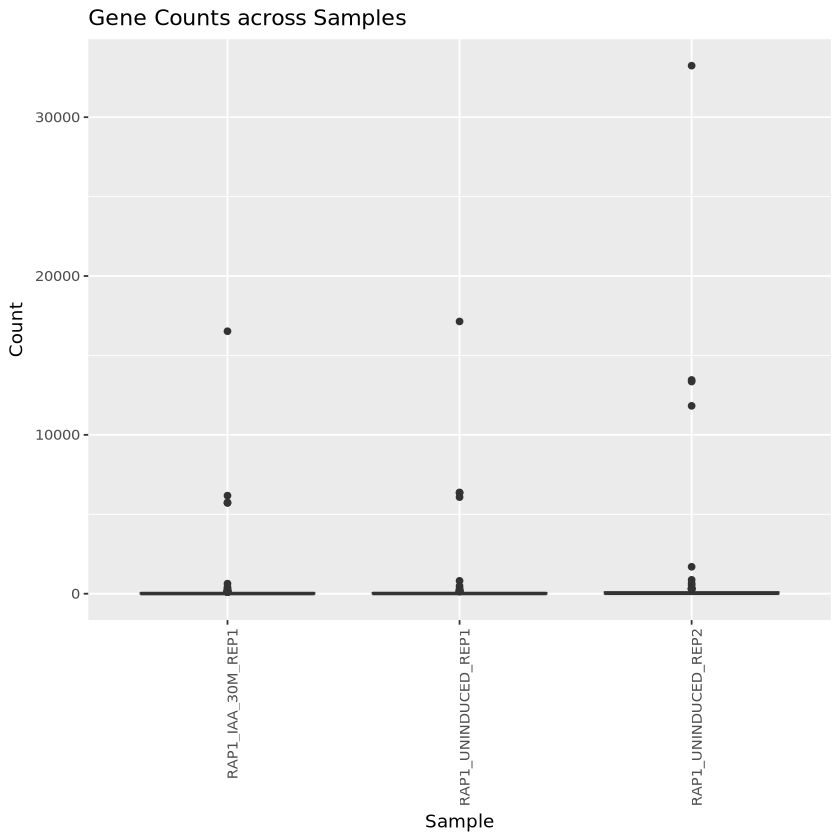

In [4]:
# Function to read and inspect Salmon results
read_salmon_results <- function(file_path) {
  data <- read_tsv(file_path)
  return(data)
}

# Read gene counts and gene TPM
gene_counts <- read_salmon_results(gene_counts_file)
gene_tpm <- read_salmon_results(gene_tpm_file)

# Ensure gene_name is character type
gene_counts <- gene_counts %>%
  mutate(gene_name = as.character(gene_name))

# Print the structure of gene_counts to verify data types
str(gene_counts)

# Function to pivot data and handle data types
pivot_gene_counts <- function(data) {
  data %>%
    pivot_longer(cols = starts_with("RAP1"), 
                 names_to = "sample", 
                 values_to = "count")
}

# Pivot gene counts and handle any data type issues
tryCatch({
  gene_counts_long <- pivot_gene_counts(gene_counts)
  
  # Visualization: Plot gene counts from Salmon results
  ggplot(gene_counts_long, aes(x = sample, y = count)) +
    geom_boxplot() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = "Gene Counts across Samples", x = "Sample", y = "Count")
}, error = function(e) {
  cat("Error occurred while pivoting gene counts:", conditionMessage(e), "\n")
  # Handle error gracefully
})

# Read and inspect Tx2Gene mapping
tx2gene <- read_salmon_results(tx2gene_file)
cat("\nTx2Gene Mapping:\n")
print(head(tx2gene))

